In [1]:
import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
pd.set_option("display.max_columns", 120)
print("pandas", pd.__version__)


pandas 2.3.1


In [2]:

CAND_PATHS = [
    Path("../outputs/day_inperson_ready.csv"),
]

for p in CAND_PATHS:
    if p.exists():
        DAY_PATH = p
        break
else:
    raise FileNotFoundError("找不到 day_inperson_ready.csv，请将其放到 outputs/ 下或修改路径。")

day_ip = pd.read_csv(DAY_PATH, low_memory=False)
# 尝试日期转型（若存在）
for c in ["_date","date"]:
    if c in day_ip.columns:
        day_ip[c] = pd.to_datetime(day_ip[c], errors="coerce")
        if c != "_date":
            day_ip.rename(columns={c:"_date"}, inplace=True)

print("Loaded:", DAY_PATH, "shape:", day_ip.shape)
day_ip.head(3)


Loaded: ..\outputs\day_inperson_ready.csv shape: (7860, 31)


,_id,_date,day_total_amount,n_tx,n_low_tx,T_share_low,Y_log_amt,_weekday,mshare_1,mshare_2,mshare_3,mshare_4,mshare_5,mshare_6,mshare_7,mshare_8,mshare_9,mshare_10,mshare_12,mshare_13,mshare_14,mshare_15,mshare_16,mshare_17,mshare_18,mshare_19,mshare_20,mshare_21,T_share_low_trim,active_persons,w_day
0,100001,2024-10-13,50.00,1,0,0.0,3.931826,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.05,257,1.217288
1,100001,2024-10-14,40.24,1,1,1.0,3.719409,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.95,259,1.226761
2,100003,2024-10-27,18.00,1,0,0.0,2.944439,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.05,292,1.383067


In [3]:
def make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=np.float32)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False, dtype=np.float32)


In [4]:
def cluster_bootstrap_theta(df, X_cols, T_col, Y_col, B=100, seed=2027, use_day_weight=True):
    rng = np.random.default_rng(seed)
    ids = df["_id"].unique()
    thetas = []

    for b in range(B):
        samp_ids = rng.choice(ids, size=len(ids), replace=True)
        sub = df[df["_id"].isin(samp_ids)].dropna(subset=X_cols + [T_col, Y_col]).copy()

        sw = None
        if use_day_weight and "w_day" in sub.columns:
            sw = sub["w_day"].values

        th, _, _ = dml_partialling_out_weighted(
            sub[X_cols], sub[T_col].values, sub[Y_col].values,
            sample_weight=sw, n_splits=5, seed=42 + b
        )
        thetas.append(th)

    thetas = np.array(thetas)
    ci = (np.percentile(thetas, 2.5), np.percentile(thetas, 97.5))
    return float(thetas.mean()), (float(ci[0]), float(ci[1])), len(thetas)


In [5]:
def dml_partialling_out_weighted(X_df, T, Y, sample_weight=None, n_splits=5, seed=42):
    """
    Return theta = E[(T - ê(X)) (Y - m̂(X))] / E[(T - ê(X))^2]
    ê, m̂ 用随机森林回归（可替换为更强模型）
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    n = len(Y)
    y_res = np.zeros(n)
    t_res = np.zeros(n)
    W = np.ones(n) if sample_weight is None else np.asarray(sample_weight)

    # 预处理：weekday 做 OHE，merch份额直通
    X_cat = ["_weekday"]
    X_mer = [c for c in X_df.columns if str(c).startswith("mshare_")]
    pre = ColumnTransformer([
        ("cat", make_ohe(), X_cat),
        ("mer", "passthrough", X_mer)
    ])

    for tr, te in kf.split(X_df):
        Xt, Xv = X_df.iloc[tr], X_df.iloc[te]
        Tt, Tv = T[tr], T[te]
        Yt, Yv = Y[tr], Y[te]
        Wt = W[tr]

        Zt = pre.fit_transform(Xt)
        Zv = pre.transform(Xv)

        fY = RandomForestRegressor(n_estimators=400, n_jobs=-1, random_state=seed).fit(Zt, Yt, sample_weight=Wt)
        fT = RandomForestRegressor(n_estimators=400, n_jobs=-1, random_state=seed).fit(Zt, Tt, sample_weight=Wt)

        y_res[te] = Yv - fY.predict(Zv)
        t_res[te] = Tv - fT.predict(Zv)

    w = W / W.mean()
    theta = np.average(t_res * y_res, weights=w) / np.average(t_res**2, weights=w)
    return float(theta), t_res, y_res


In [6]:
# 关键列存在性
req_cols = ["_id","_date","T_share_low","Y_log_amt","_weekday"]
missing = [c for c in req_cols if c not in day_ip.columns]
if missing:
    raise ValueError(f"缺少关键列: {missing}。请确认 02_build_inperson_day.ipynb 生成的表结构。")

# 若有修剪列就用修剪列；否则用原始占比
T_col = "T_share_low_trim" if "T_share_low_trim" in day_ip.columns else "T_share_low"
print("Treatment column:", T_col)

# 特征列：weekday + merch篮子份额
X_cols = ["_weekday"] + [c for c in day_ip.columns if str(c).startswith("mshare_")]
print("X columns (#):", len(X_cols), " → ", X_cols[:8], "..." if len(X_cols)>8 else "")
print(day_ip[[T_col, "Y_log_amt"] + X_cols].isna().mean().sort_values(ascending=False).head(8))


Treatment column: T_share_low_trim
X columns (#): 21  →  ['_weekday', 'mshare_1', 'mshare_2', 'mshare_3', 'mshare_4', 'mshare_5', 'mshare_6', 'mshare_7'] ...
T_share_low_trim    0.0
Y_log_amt           0.0
_weekday            0.0
mshare_1            0.0
mshare_2            0.0
mshare_3            0.0
mshare_4            0.0
mshare_5            0.0
dtype: float64


# 加入 Rich CoVar


In [7]:
from pathlib import Path
import numpy as np
import pandas as pd

# ---------- 1. 找 ind/day 原始 CSV ----------
IND_CANDS = [
    Path("../data/dcpc_2024_indlevel_public.csv"),
]
DAYRAW_CANDS = [
    Path("../data/dcpc_2024_daylevel_public.csv"),
]
TRAN_CANDS = [
    Path("../data/dcpc_2024_tranlevel_public.csv"),
]

def pick_path(cands):
    for p in cands:
        if p.exists():
            return p
    raise FileNotFoundError("File not found in candidates: " + ", ".join(map(str, cands)))

IND_PATH    = pick_path(IND_CANDS)
DAYRAW_PATH = pick_path(DAYRAW_CANDS)
print("Using IND:", IND_PATH)
print("Using DAY RAW:", DAYRAW_PATH)

ind_raw = pd.read_csv(IND_PATH, low_memory=False)
day_raw = pd.read_csv(DAYRAW_PATH, low_memory=False)


Using IND: ..\data\dcpc_2024_indlevel_public.csv
Using DAY RAW: ..\data\dcpc_2024_daylevel_public.csv


In [8]:

# ---------- 2. 对齐 id / date ----------
# ind 对齐 _id
id_ind = None
for c in ["_id","id","person_id","PID"]:
    if c in ind_raw.columns:
        id_ind = c
        break
if id_ind is None:
    raise ValueError("ind-level 没找到 id 列")

ind_raw.rename(columns={id_ind: "_id"}, inplace=True)
ind_raw["_id"] = pd.to_numeric(ind_raw["_id"], errors="coerce")

# day_raw 对齐 _id, _date
id_day = None
date_day = None
for c in ["_id","id","person_id","PID"]:
    if c in day_raw.columns:
        id_day = c
        break
for c in ["_date","date","diary_date"]:
    if c in day_raw.columns:
        date_day = c
        break
if id_day is None or date_day is None:
    raise ValueError("day-level 没找到 id 或 date 列")

day_raw.rename(columns={id_day: "_id", date_day: "_date"}, inplace=True)
day_raw["_id"]   = pd.to_numeric(day_raw["_id"], errors="coerce")
day_raw["_date"] = pd.to_datetime(day_raw["_date"], errors="coerce")

# 确保 day_ip 的 _date 是 datetime
day_ip["_date"] = pd.to_datetime(day_ip["_date"], errors="coerce")


In [9]:

# ---------- 3. 从 ind 里挑几类直观特征 ----------
# 用关键词自动挑一些列（income/education/age/household/employ）
ind_keywords = ["income", "inc_", "educ", "school", "age", "employ", "work", "job",
                "hhsize", "household", "marital", "married"]
ind_cols = [c for c in ind_raw.columns
            if any(kw in c.lower() for kw in ind_keywords)]

# 去掉太高维的（比如全是 dummies 的那种），简单处理：排除 unique 太多的 id-like 列
ind_cols = [c for c in ind_cols if ind_raw[c].nunique() < 50]

print("\nSelected ind-level features:")
print(ind_cols)

ind_small = ind_raw[["_id"] + ind_cols].copy()
day_ip = day_ip.merge(ind_small, on="_id", how="left")



Selected ind-level features:
['agerange', 'highest_education', 'work_occupation', 'hhincome', 'marital_status', 'workfullpart', 'inc_doyouget_employment', 'inc_doyouget_empretire', 'inc_doyouget_selfemployment', 'inc_doyouget_socsec', 'inc_doyouget_interest', 'inc_doyouget_rental', 'inc_doyouget_govtasst', 'inc_doyouget_alimony', 'inc_doyouget_childsupport', 'inc_doyouget_otherretire', 'inc_howoften_employment', 'inc_howoften_empretire', 'inc_howoften_selfemployment', 'inc_howoften_socsec', 'inc_howoften_interest', 'inc_howoften_rental', 'inc_howoften_govtasst', 'inc_howoften_alimony', 'inc_howoften_childsupport', 'inc_howoften_otherretire', 'work_employed', 'work_onleave', 'work_temp_unemployed', 'work_looking', 'work_retired', 'work_disabled', 'work_other', 'work_self']


In [10]:

# ---------- 4. 从 day_raw 里挑一些 "day-state" 特征 ----------
# 比如 bill / pay / income / transfer 等
day_keywords = ["bill", "pay", "income", "inc_", "rent", "mortgage", "salary", "wage"]
day_state_cols = [c for c in day_raw.columns
                  if any(kw in c.lower() for kw in day_keywords)]

# 也简单限制一下维度
day_state_cols = [c for c in day_state_cols if day_raw[c].nunique() < 50]

print("\nSelected day-state features:")
print(day_state_cols)

day_small = day_raw[["_id","_date"] + day_state_cols].copy()
day_ip = day_ip.merge(day_small, on=["_id","_date"], how="left")



Selected day-state features:
['inc_amnt_rental', 'inc_amnt_alimony', 'inc_amnt_childsupport', 'inc_amnt_otherretire', 'inc_method_employment', 'inc_method_empretire', 'inc_method_selfemployment', 'inc_method_socsec', 'inc_method_interest', 'inc_method_rental', 'inc_method_govtasst', 'inc_method_alimony', 'inc_method_childsupport', 'inc_method_otherretire', 'carry_paypal', 'numberofpayments', 'anypayments', 'nopayments']


In [11]:

# ---------- 5. 如果还没有 day_max_txn，就从 STRICT in-person 交易里算 ----------
if "day_max_txn" not in day_ip.columns:
    print("\nNo 'day_max_txn' in day_ip, rebuilding from TRAN (STRICT rule)...")
    TRAN_PATH = pick_path(TRAN_CANDS)
    tran = pd.read_csv(TRAN_PATH, low_memory=False)
    
    # 对齐 id/date/amount
    id_tr = None
    date_tr = None
    amt_tr = None
    for c in ["_id","id","person_id","PID"]:
        if c in tran.columns:
            id_tr = c
            break
    for c in ["_date","date"]:
        if c in tran.columns:
            date_tr = c
            break
    for c in ["_amount","amnt","amount"]:
        if c in tran.columns:
            amt_tr = c
            break

    tran.rename(columns={id_tr:"_id", date_tr:"_date", amt_tr:"_amount"}, inplace=True)
    tran["_id"]   = pd.to_numeric(tran["_id"], errors="coerce")
    tran["_date"] = pd.to_datetime(tran["_date"], errors="coerce")
    tran["_amount"] = pd.to_numeric(tran["_amount"], errors="coerce")

    # 只保留真实支付 + in-person
    is_payment = (tran.get("payment", 1) == 1) & (tran.get("nonpaymenttran").isna())
    tran = tran[is_payment].copy()
    tran["_inperson"] = pd.to_numeric(tran.get("in_person"), errors="coerce")
    tran = tran[tran["_inperson"] == 1].copy()

    # STRICT PI 规则
    tran["pi"] = pd.to_numeric(tran.get("pi"), errors="coerce")
    STRICT_LOW  = {3,4,6,7}
    STRICT_HIGH = {1,2,8}
    STRICT_KEEP = STRICT_LOW | STRICT_HIGH
    tran = tran[tran["pi"].isin(STRICT_KEEP)].copy()

    gmax = tran.groupby(["_id","_date"])["_amount"].max().rename("day_max_txn")
    day_ip = day_ip.merge(gmax, on=["_id","_date"], how="left")

print("\n'day_max_txn' describe:")
print(day_ip["day_max_txn"].describe())



No 'day_max_txn' in day_ip, rebuilding from TRAN (STRICT rule)...

'day_max_txn' describe:
count     7639.000000
mean       110.720452
std        560.122713
min          0.000000
25%         17.000000
50%         37.000000
75%         80.000000
max      30050.000000
Name: day_max_txn, dtype: float64


In [12]:

# ---------- 6. 设置价格 cap (单日最大单笔) ----------
CAP = 150   # 你可以改成 200 看 sensitivity
day_cap = day_ip[day_ip["day_max_txn"].notna() & (day_ip["day_max_txn"] <= CAP)].copy()
print(f"\nCAP = {CAP}: kept {len(day_cap)}/{len(day_ip)} days  ({len(day_cap)/len(day_ip):.1%})")

# ---------- 7. 构造 Rich X & 分析样本 ----------
X_cols_rich = (["_weekday"]
               + [c for c in day_cap.columns if str(c).startswith("mshare_")]
               + ind_cols
               + day_state_cols)

# 去重防万一
X_cols_rich = list(dict.fromkeys(X_cols_rich))

print("\nRich X columns (dim={}):".format(len(X_cols_rich)))
print(X_cols_rich)

sub_rich = day_cap.dropna(subset=[T_col, "Y_log_amt"] + X_cols_rich).copy()
print("\nRich DML sample: rows =", len(sub_rich), "  persons =", sub_rich["_id"].nunique())



CAP = 150: kept 6758/7860 days  (86.0%)

Rich X columns (dim=73):
['_weekday', 'mshare_1', 'mshare_2', 'mshare_3', 'mshare_4', 'mshare_5', 'mshare_6', 'mshare_7', 'mshare_8', 'mshare_9', 'mshare_10', 'mshare_12', 'mshare_13', 'mshare_14', 'mshare_15', 'mshare_16', 'mshare_17', 'mshare_18', 'mshare_19', 'mshare_20', 'mshare_21', 'agerange', 'highest_education', 'work_occupation', 'hhincome', 'marital_status', 'workfullpart', 'inc_doyouget_employment', 'inc_doyouget_empretire', 'inc_doyouget_selfemployment', 'inc_doyouget_socsec', 'inc_doyouget_interest', 'inc_doyouget_rental', 'inc_doyouget_govtasst', 'inc_doyouget_alimony', 'inc_doyouget_childsupport', 'inc_doyouget_otherretire', 'inc_howoften_employment', 'inc_howoften_empretire', 'inc_howoften_selfemployment', 'inc_howoften_socsec', 'inc_howoften_interest', 'inc_howoften_rental', 'inc_howoften_govtasst', 'inc_howoften_alimony', 'inc_howoften_childsupport', 'inc_howoften_otherretire', 'work_employed', 'work_onleave', 'work_temp_unemp

In [13]:
# === Debug + 修复 X_cols_rich，避免 sub_rich 变成空 ===
print("Before filtering, X_cols_rich dim =", len(X_cols_rich))

# 1. 只保留 day_cap 里确实存在的列（防止误选不存在的）
X_cols_rich = [c for c in X_cols_rich if c in day_cap.columns]
print("After intersect with day_cap, dim =", len(X_cols_rich))

# 2. 计算每个候选特征的非缺失比例 & 唯一值个数
na_rate = day_cap[X_cols_rich].isna().mean()
nnz_rate = 1 - na_rate
nuniq = day_cap[X_cols_rich].nunique(dropna=True)

diag = pd.DataFrame({
    "nnz_rate": nnz_rate,
    "nuniq": nuniq
}).sort_values(["nnz_rate","nuniq"], ascending=[False, True])

print("\nTop 20 rich features by non-missing rate:")
display(diag.head(20))

# 3. 过滤规则
#    - 至少 80% 的非缺失
#    - 至少 2 个取值（排除全是常数/全 0 列）
MIN_NNZ = 0.80
X_keep = [c for c in X_cols_rich
          if nnz_rate[c] >= MIN_NNZ and nuniq[c] > 1]

print(f"\nFiltered rich X (nnz >= {MIN_NNZ:.2f}, nuniq > 1) → dim =", len(X_keep))
print(X_keep)

# 4. 用过滤后的 X_keep 重建 sub_rich
X_cols_rich = X_keep
sub_rich = day_cap.dropna(subset=[T_col, "Y_log_amt"] + X_cols_rich).copy()

print("\nRich DML sample after filtering:")
print("  rows   =", len(sub_rich))
print("  persons=", sub_rich["_id"].nunique())

# 如果样本还是太少，可以考虑：
#  - 降低 MIN_NNZ，比如 0.2
#  - 或者先不加某一大类的 ind/day 特征，分步加

Before filtering, X_cols_rich dim = 73
After intersect with day_cap, dim = 73

Top 20 rich features by non-missing rate:


,nnz_rate,nuniq
marital_status,1.0,6
_weekday,1.0,7
mshare_13,1.0,8
mshare_14,1.0,8
mshare_8,1.0,9
mshare_10,1.0,9
mshare_12,1.0,9
mshare_15,1.0,9
mshare_19,1.0,10
mshare_17,1.0,11



Filtered rich X (nnz >= 0.80, nuniq > 1) → dim = 44
['_weekday', 'mshare_1', 'mshare_2', 'mshare_3', 'mshare_4', 'mshare_5', 'mshare_6', 'mshare_7', 'mshare_8', 'mshare_9', 'mshare_10', 'mshare_12', 'mshare_13', 'mshare_14', 'mshare_15', 'mshare_16', 'mshare_17', 'mshare_18', 'mshare_19', 'mshare_20', 'mshare_21', 'highest_education', 'hhincome', 'marital_status', 'inc_doyouget_employment', 'inc_doyouget_empretire', 'inc_doyouget_selfemployment', 'inc_doyouget_socsec', 'inc_doyouget_interest', 'inc_doyouget_rental', 'inc_doyouget_govtasst', 'inc_doyouget_alimony', 'inc_doyouget_childsupport', 'inc_doyouget_otherretire', 'work_employed', 'work_onleave', 'work_temp_unemployed', 'work_looking', 'work_retired', 'work_disabled', 'work_other', 'carry_paypal', 'numberofpayments', 'anypayments']

Rich DML sample after filtering:
  rows   = 5760
  persons= 3670


In [14]:
# Remove bad covariates that lead to errors
bad_covariates = ['inc_doyouget_alimony', 'work_temp_unemployed', 'work_onleave']

for bc in bad_covariates:
    if bc in X_cols_rich:
        X_cols_rich.remove(bc)
        print(f"Removed bad covariate: {bc}")
print("Final rich X columns (dim={}):".format(len(X_cols_rich)))
print(X_cols_rich)

Removed bad covariate: inc_doyouget_alimony
Removed bad covariate: work_temp_unemployed
Removed bad covariate: work_onleave
Final rich X columns (dim=41):
['_weekday', 'mshare_1', 'mshare_2', 'mshare_3', 'mshare_4', 'mshare_5', 'mshare_6', 'mshare_7', 'mshare_8', 'mshare_9', 'mshare_10', 'mshare_12', 'mshare_13', 'mshare_14', 'mshare_15', 'mshare_16', 'mshare_17', 'mshare_18', 'mshare_19', 'mshare_20', 'mshare_21', 'highest_education', 'hhincome', 'marital_status', 'inc_doyouget_employment', 'inc_doyouget_empretire', 'inc_doyouget_selfemployment', 'inc_doyouget_socsec', 'inc_doyouget_interest', 'inc_doyouget_rental', 'inc_doyouget_govtasst', 'inc_doyouget_childsupport', 'inc_doyouget_otherretire', 'work_employed', 'work_looking', 'work_retired', 'work_disabled', 'work_other', 'carry_paypal', 'numberofpayments', 'anypayments']


In [15]:
th, ci, B_used = cluster_bootstrap_theta(
    sub_rich,
    X_cols=X_cols_rich,
    T_col=T_col,
    Y_col="Y_log_amt",
    B=10,
    seed=2027,
    use_day_weight=("w_day" in sub_rich.columns)
)
delta10 = 0.10 * th
rel_pct = (np.exp(delta10) - 1) * 100
print(f"[DML rich X, cap={CAP}] theta={th:.4f}  95%CI=({ci[0]:.4f},{ci[1]:.4f})  → per +10pp ≈ {rel_pct:.1f}%   (B={B_used})")
print("Rows used:", len(sub_rich), "  Unique persons:", sub_rich['_id'].nunique())


[DML rich X, cap=150] theta=0.5510  95%CI=(0.5090,0.5911)  → per +10pp ≈ 5.7%   (B=10)
Rows used: 5760   Unique persons: 3670


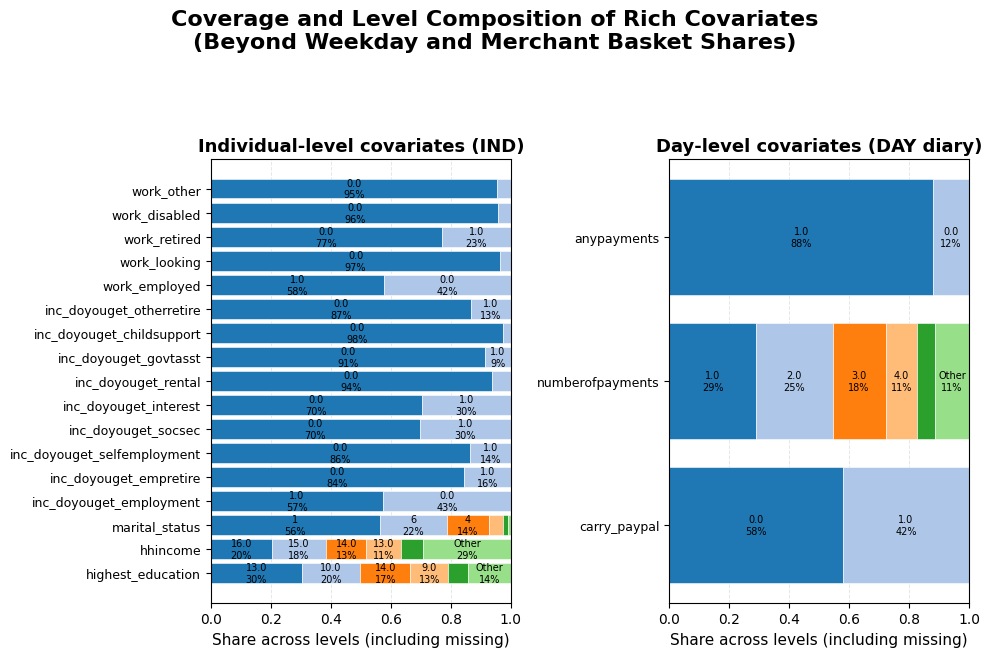

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === 3. 每个 bar 显示各 level 的占比（含缺失） ===

def build_level_shares(df, cols, max_levels=6):
    """
    对每个变量，返回 (变量名, 各 level 占比的 Series) 的列表。
    level 中把缺失单独标成 'MISSING'，如果水平太多就 top-K + Other。
    """
    result = []
    for col in cols:
        if col not in df.columns:
            continue

        s = df[col]

        # 把缺失当成一个类别
        s_cat = s.where(~s.isna(), "MISSING")

        # 占比
        vc = s_cat.value_counts(normalize=True)

        # 如果水平太多，就只保留前 max_levels-1，剩下合并为 Other
        if len(vc) > max_levels:
            top = vc.iloc[: max_levels - 1]
            other_share = vc.iloc[max_levels - 1 :].sum()
            vc = pd.concat([top, pd.Series({"Other": other_share})])

        # 不管有没有截断，都要 append
        result.append((col, vc))

    return result


def plot_level_panel(ax, level_shares, title):
    """画一个 panel：每个变量一条堆叠 bar，显示各 level 的 share。"""
    if len(level_shares) == 0:
        ax.text(
            0.5,
            0.5,
            "No covariates in this group",
            ha="center",
            va="center",
            fontsize=11,
            alpha=0.7,
        )
        ax.set_xlim(0, 1.0)
        ax.set_xticks([0, 0.5, 1.0])
        ax.set_xlabel("Share across levels (including missing)", fontsize=11)
        ax.set_title(title, fontsize=13, fontweight="bold")
        ax.grid(axis="x", alpha=0.3, linestyle="--", linewidth=0.7)
        ax.set_axisbelow(True)
        ax.set_yticks([])
        return

    y_pos = np.arange(len(level_shares))
    cmap = plt.get_cmap("tab20")

    # 逐个变量画堆叠 bar
    for i, (col, vc) in enumerate(level_shares):
        left = 0.0
        for j, (lvl, share) in enumerate(vc.items()):
            ax.barh(
                i,
                share,
                left=left,
                color=cmap(j),
                edgecolor="white",
                linewidth=0.4,
            )

            # 大于 8% 的段在内部标注 level + 百分比，小段就不标了
            if share > 0.08:
                ax.text(
                    left + share / 2,
                    i,
                    f"{lvl}\n{share*100:.0f}%",
                    ha="center",
                    va="center",
                    fontsize=7,
                )
            left += share

    ax.set_yticks(y_pos)
    ax.set_yticklabels([col for col, _ in level_shares], fontsize=9)
    ax.set_xlim(0, 1.0)
    ax.set_xlabel("Share across levels (including missing)", fontsize=11)
    ax.set_title(title, fontsize=13, fontweight="bold")
    ax.grid(axis="x", alpha=0.3, linestyle="--", linewidth=0.7)
    ax.set_axisbelow(True)


# --- 基于 X_cols_rich 选 covariates，并排除 weekday / merchant shares ---

weekday_col = "_weekday"
mshare_cols = [c for c in X_cols_rich if c.startswith("mshare_")]

# 只考虑在 X_cols_rich 中、且真的出现在 sub_rich 的列
plot_cols = [c for c in X_cols_rich if c in sub_rich.columns]

# 去掉 weekday + merchant share，只留下 “rich covariates”
extra_covs = [c for c in plot_cols if c not in mshare_cols + [weekday_col]]

# 这里假设你之前已经有 ind_cols / day_state_cols
# 用它们来把 extra_covs 分成 IND-level 和 DAY-level
ind_extra = [c for c in extra_covs if c in ind_cols]
day_extra = [c for c in extra_covs if c in day_state_cols]

# 构造 IND 和 DAY 的 level 占比信息
ind_level_shares = build_level_shares(sub_rich, ind_extra, max_levels=6)
day_level_shares = build_level_shares(sub_rich, day_extra, max_levels=6)

# 根据变量个数自动调整高度
max_n = max(len(ind_level_shares), len(day_level_shares), 1)
fig_height = max(5, 0.4 * max_n)

fig, axes = plt.subplots(1, 2, figsize=(10, fig_height), sharex=True)
fig.suptitle(
    "Coverage and Level Composition of Rich Covariates\n"
    "(Beyond Weekday and Merchant Basket Shares)",
    fontsize=16,
    fontweight="bold",
)

plot_level_panel(axes[0], ind_level_shares, "Individual-level covariates (IND)")
plot_level_panel(axes[1], day_level_shares, "Day-level covariates (DAY diary)")

plt.tight_layout(rect=[0, 0.02, 1, 0.90])
plt.show()
